In [1]:
# data
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
# load dataset
df = pd.read_csv("./credit_risk_dataset.csv")
df

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


<h3>Description of the dataset<h3>

<h5>    person_age: Age of the individual applying for the loan.
    person_income: Annual income of the individual.
    person_home_ownership: Type of home ownership of the individual.
        rent: The individual is currently renting a property.
        mortgage: The individual has a mortgage on the property they own.
        own: The individual owns their home outright.
        other: Other categories of home ownership that may be specific to the dataset.
    person_emp_length: Employment length of the individual in years.
    loan_intent: The intent behind the loan application.
    loan_grade: The grade assigned to the loan based on the creditworthiness of the borrower.
        A: The borrower has a high creditworthiness, indicating low risk.
        B: The borrower is relatively low-risk, but not as creditworthy as Grade A.
        C: The borrower's creditworthiness is moderate.
        D: The borrower is considered to have higher risk compared to previous grades.
        E: The borrower's creditworthiness is lower, indicating a higher risk.
        F: The borrower poses a significant credit risk.
        G: The borrower's creditworthiness is the lowest, signifying the highest risk.
    loan_amnt: The loan amount requested by the individual.
    loan_int_rate: The interest rate associated with the loan.
    loan_status: Loan status, where 0 indicates non-default and 1 indicates default.
        0: Non-default - The borrower successfully repaid the loan as agreed, and there was no default.
        1: Default - The borrower failed to repay the loan according to the agreed-upon terms and defaulted on the loan.
    loan_percent_income: The percentage of income represented by the loan amount.
    cb_person_default_on_file: Historical default of the individual as per credit bureau records.
        Y: The individual has a history of defaults on their credit file.
        N: The individual does not have any history of defaults.
    cb_preson_cred_hist_length: The length of credit history for the individual.<h5>

In [ ]:
# determine number of NaN values in the dataset
df.isnull().sum()

In [ ]:
# To simplify this code, we just remove outliers (imputing is not of interest here)
df.dropna(axis=0, inplace=True)
df.isnull().sum()

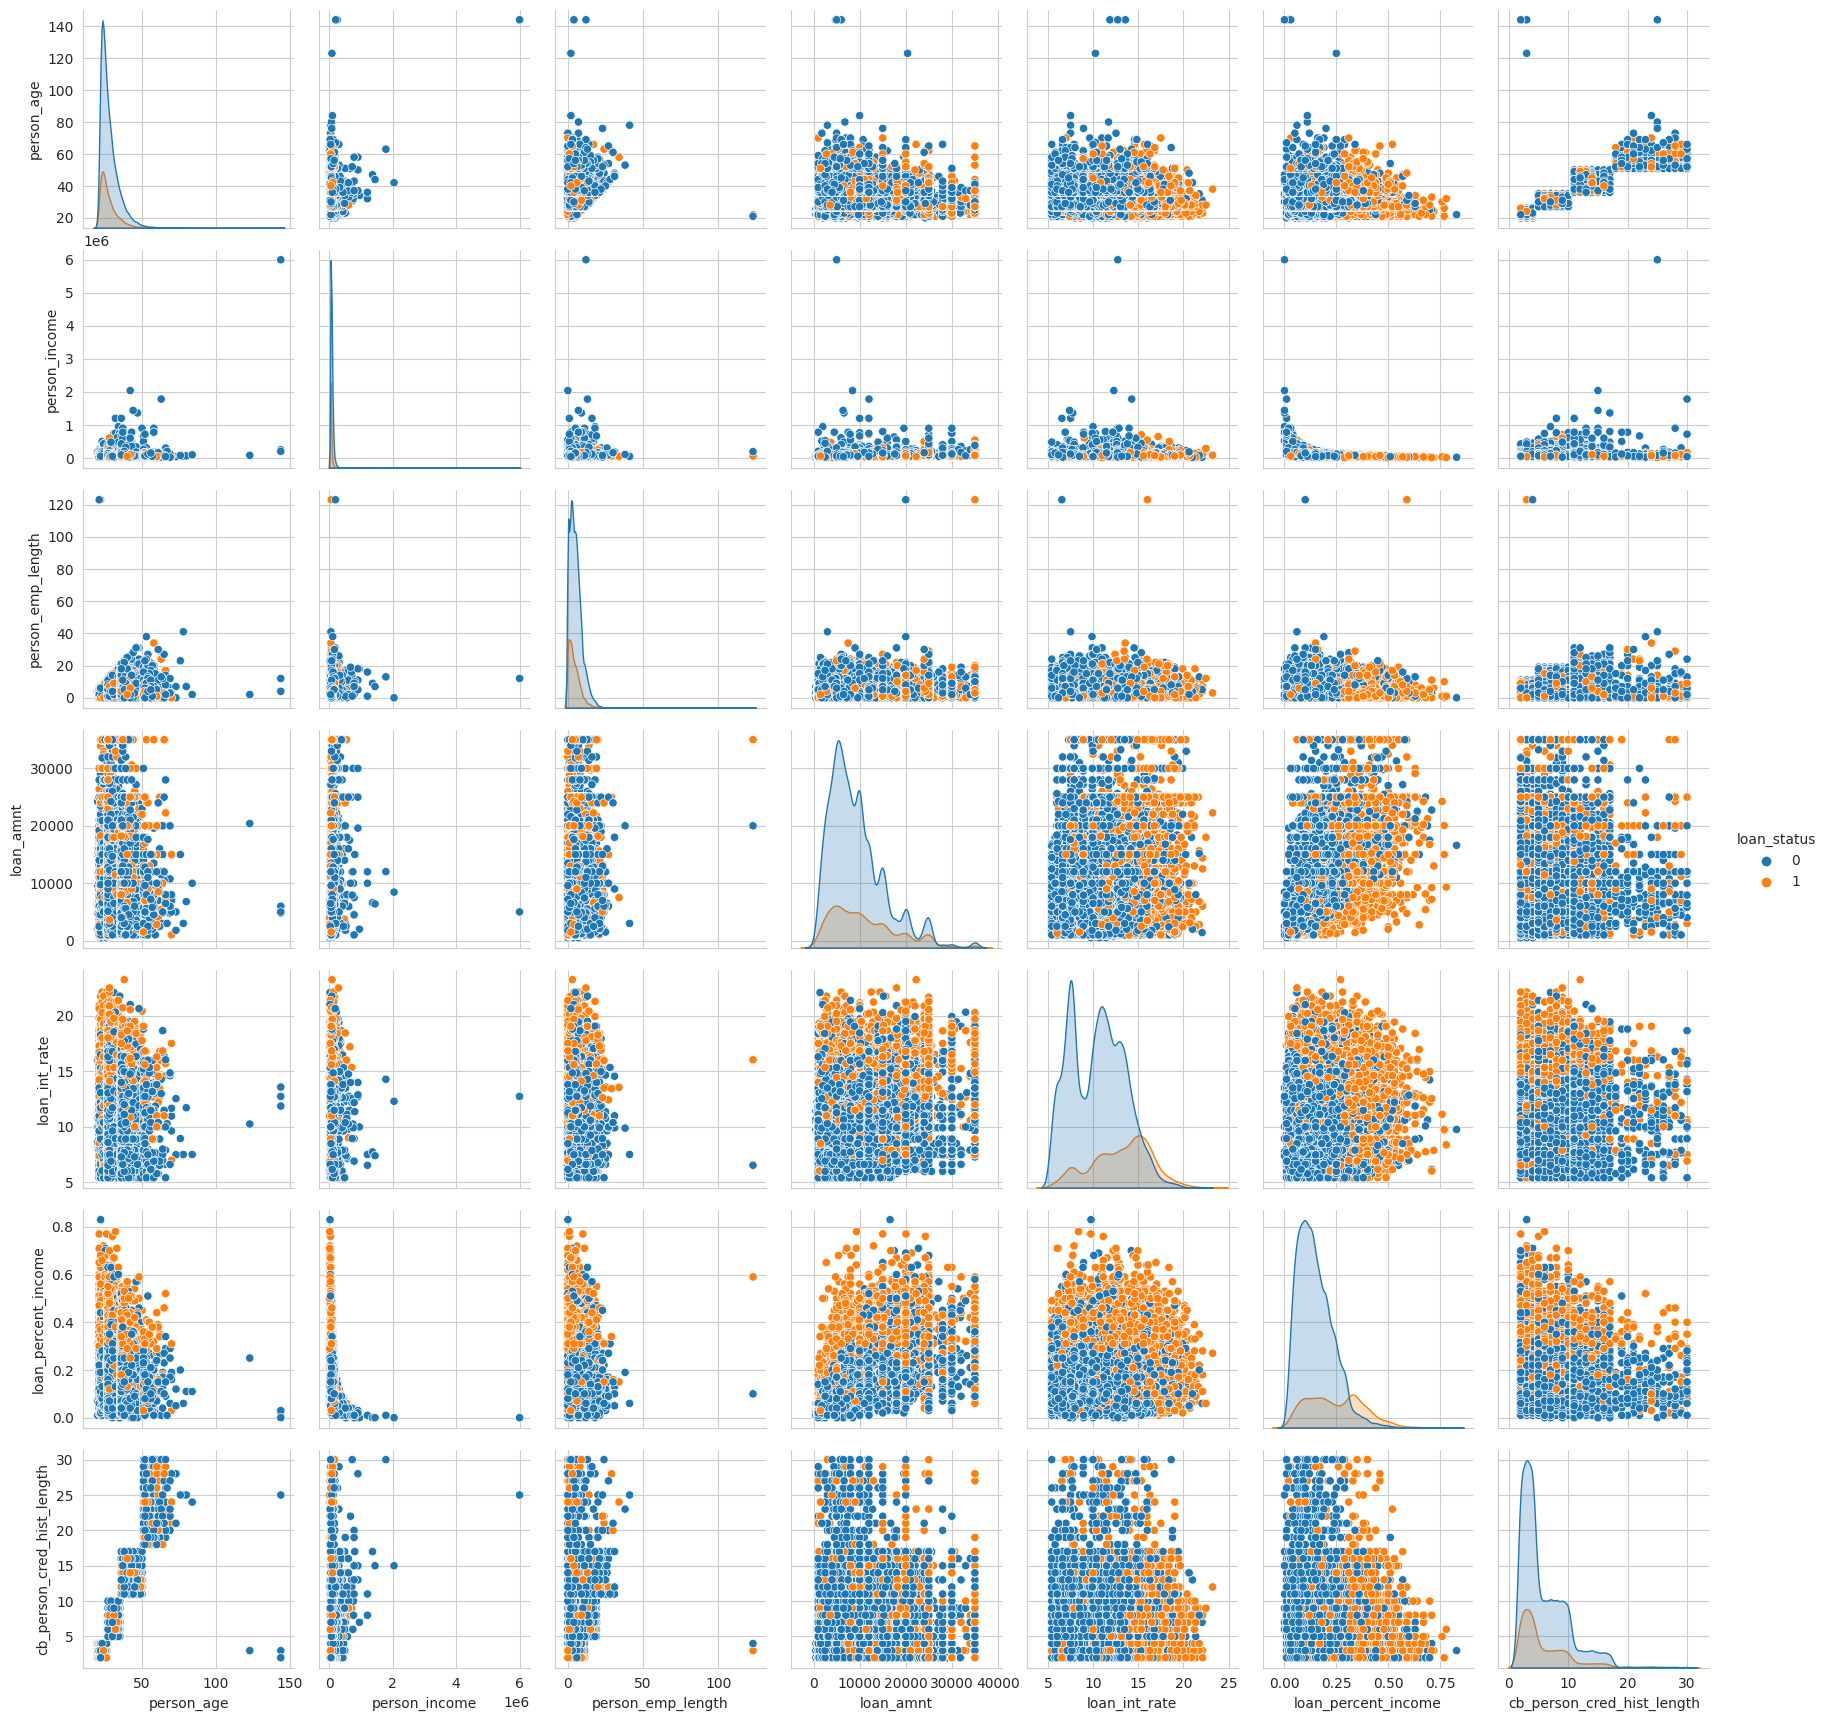

In [5]:
# pairplot for the numerical fields
pairplot = sns.pairplot(df, hue="loan_status")
for ax in pairplot.axes.flatten():
    ax.tick_params(axis='x')
    ax.tick_params(axis='y')

As can be observed, appears several outliers in the dataset coming from the fields: person_age, person_income and person_emp_lenght. Easily these outliers can be removing applying e.g. person_age < 80, person_income < 3e6 and person_emp_lenght < 60, but in this tutorial we want to deal with them in other ways. Firstly, we will create several copies of the original dataframe for manipulation.

<h3> 1. Box-whisker approach (univariate) <h3>

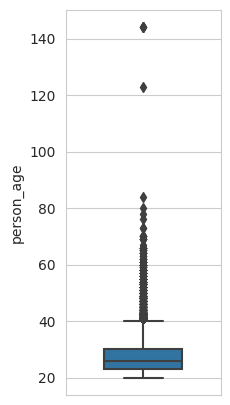

In [6]:
plt.figure(figsize=(2,5))
ax = sns.boxplot(y=df.person_age, orient="h", width=0.5, whis=1.5)

In [7]:
def get_quartiles(df, column, whisker=1.5):

    q25, q75 = np.quantile(df[column], 0.25), np.quantile(df[column], 0.75)
    iqr = q75 - q25
    cut_off = iqr*whisker
    lower, upper = q25-cut_off, q75+cut_off
    print(f'The IQR is: {iqr}')
    print(f'The lower bound value is: {lower}')
    print(f'The upper bound value is: {upper}')
    # Calculate the number of records below and above lower and above bound value respectively.
    outliers_up  = df[df[column] > upper]
    outliers_low = df[df[column] < lower]
    print(f'Total number of outliers are {outliers_up.shape[0] + outliers_low.shape[0]}')

In [8]:
# print descriptive values of the boxplot
get_quartiles(df, 'person_age', whisker=1.5)

The IQR is: 7.0
The lower bound value is: 12.5
The upper bound value is: 40.5
Total number of outliers are 1298


IQR (interquartil range) is the width of the blue bar. Although it was printed that the lower bound is 12.5, really the minimum value in the dataset for person_age is 20 and it is why the lower whisker is 20. The line in the moddle of the blue bar corresponds to the q2 = median of the distribution. From the boxplot, xmin=q25-cut_off and xmax = q75+cut_off.

We can observe that many values greater than xmax=40.5 seems not be outliers. To include them, we can increase the param whisker (e.g. from 1.5 to 3.0) or use another approach.

<h3> 2. Standard deviation approach (univariate) <h3>

<AxesSubplot: xlabel='person_age', ylabel='Density'>

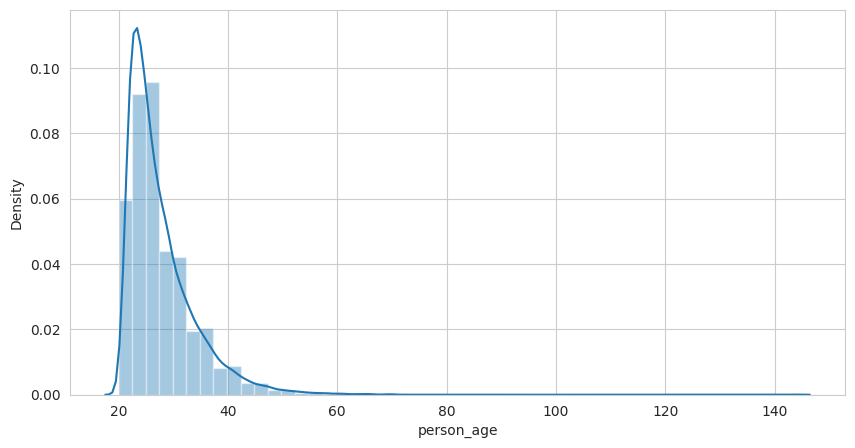

In [9]:
plt.figure(figsize = (10,5))
sns.distplot(df['person_age'])

In [10]:
def get_range(df, column, factor=3):
    """
    :param factor: number of standard deviation (width) to include data
    """
    data_mean, data_std = df[column].mean(), df[column].std()
    cut_off = data_std*3
    lower, upper = data_mean-cut_off, data_mean+cut_off
    print(f'The lower bound value is: {round(lower, 3)}')
    print(f'The upper bound value is: {round(upper, 3)}')
    outliers_up  = df[df[column] > upper]
    outliers_low = df[df[column] < lower]
    print(f'Total number of outliers are {outliers_up.shape[0] + outliers_low.shape[0]}')

In [11]:
get_range(df, 'person_age')

The lower bound value is: 8.796
The upper bound value is: 46.659
Total number of outliers are 480


We can retain xmin < person_age < xmax, with xmin=8.796 and xmax=46.659.

A range of factor=3 standard deviations includes 99.7% of data for like-gaussian (symmetric) distributions. As observed, this distribution is not symmetric because of its long tail at right. If we wished to get the value (at right) where this data percentage is included, we have to sum counts from xmin=20 to x such that counts([xmin, x])/count_total = 0.997, and determine such value for x.

<h3>3. Isolation Forest - iForest (multivariate) <h3>

This is an unsupervised machine learning algorithm for anomaly detection, based on ensemble method (forest of trees). It uses the average of the trees (estimators) when assigning the final anomally score to a given data point.

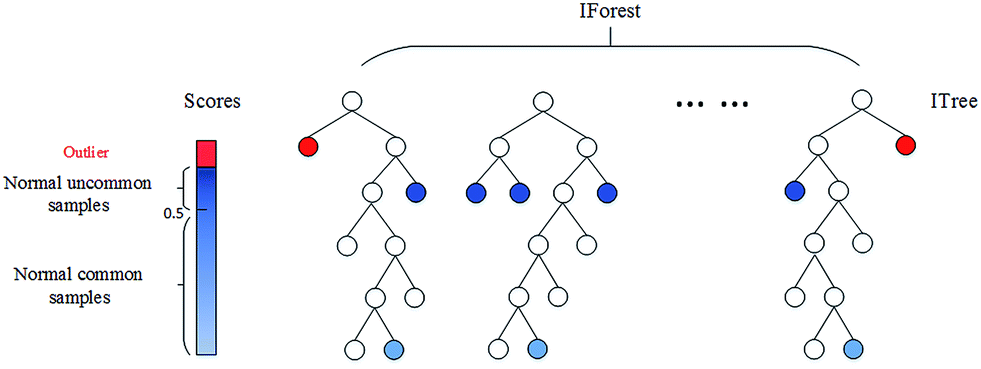

In [12]:
from IPython import display
display.Image("./graph_iForest.png")

The outliers tend to be (for each estimator) close to the root, unlike "normal" samples tend to be further.

In [13]:
def out_iForest(contamination=0.001):

    # select these two columns as example. In general, we can include all columns of the dataframe
    X = df[['person_age', 'person_income']]
    model = IsolationForest(contamination=contamination,   # default: 'auto'
                            max_samples=len(X),            # default: 256
                            n_estimators=1000,             # default: 100
                            bootstrap=True,                # default: False
                            random_state=42,
                            n_jobs=-1).fit(X)
    X['outlier'] = model.predict(X)
    # outliers are asigned the value -1. Next, we replace -1 by 0 to facilitate plotting.
    X['outlier'] = X['outlier'].replace(-1, 0)
    return X, model

In [14]:
X, model = out_iForest(contamination=0.0007)  # percentage: 0.07% given as input

In [15]:
# we can get the params used for the model creation.
model.max_samples_

28638

class 1 (inliers) = 28617
class 0 (ouliers) = 21


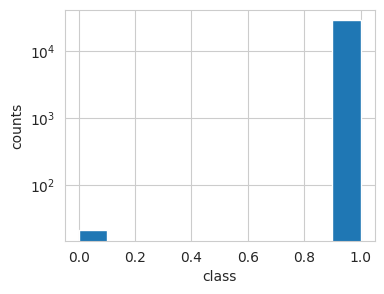

In [16]:
plt.figure(figsize=(4, 3))
plt.hist(X.outlier, log=True)

plt.xlabel("class")
plt.ylabel("counts")

print(f"class 1 (inliers) = {len(X.query('outlier == 1'))}")
print(f"class 0 (ouliers) = {len(X.query('outlier == 0'))}")

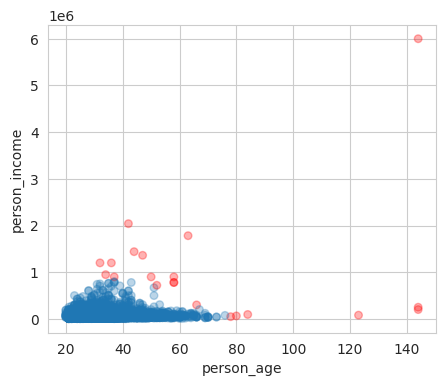

In [17]:
colors=['red','tab:blue']
point_color=[]

for row in X.outlier:
    point_color.append(colors[row])

plt.figure(figsize=(5, 4))
plt.scatter(X.person_age, X.person_income, c=point_color, s=30, alpha=0.3)
plt.xlabel("person_age")
plt.ylabel("person_income")
#plt.yscale('log')
plt.show()

Due to identifying of outliers in the dataset is easy, we can remove them using X.query('outlier != 0')

<h3> 4. DBSCAN (multivariate) <h3>

In [18]:
X = df[['person_age', 'person_income']]
X.reset_index()

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

Text(0, 0.5, 'person_income_scaled')

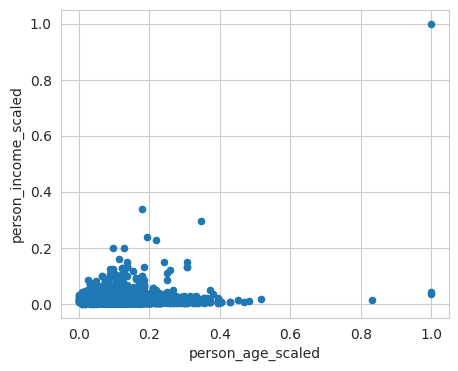

In [19]:
plt.figure(figsize=(5, 4))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], s=20)

plt.xlabel("person_age_scaled")
plt.ylabel("person_income_scaled")

DBSCAN params
* eps: maximum distance between two samples for one to be considered as in the neighborhood of the other.
* min_samples:  number of samples in a neighborhood for a point to be considered as a core point.

By default, the distance is measured using the euclidean distance.

In [20]:
clusters = DBSCAN(eps=0.04, min_samples=10, n_jobs=-1).fit_predict(X_scaled)

In [21]:
colors=['tab:blue','red']
point_color=[]

for row in clusters:
    point_color.append(colors[row])

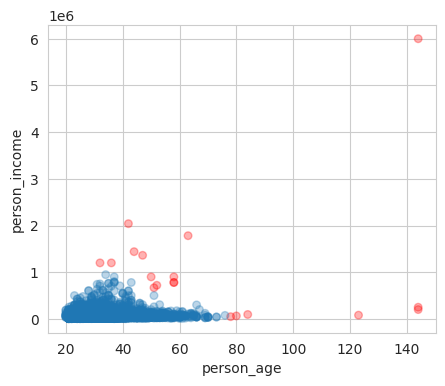

In [22]:
plt.figure(figsize=(5, 4))
plt.scatter(X.person_age, X.person_income, c=point_color, s=30, alpha=0.3)

plt.xlabel("person_age")
plt.ylabel("person_income")

#plt.yscale('log')
plt.show()

In [23]:
# outlier labels, saved in the variable clusters, can be added to our dataframe X
X['outlier'] = clusters
X

,person_age,person_income,outlier
0,22,59000,0
1,21,9600,0
2,25,9600,0
3,23,65500,0
4,24,54400,0
...,...,...,...
32576,57,53000,0
32577,54,120000,0
32578,65,76000,0
32579,56,150000,0


Now, we can use the field outlier to remove ourliers by applying: X.query('outlier != -1'), where -1 are considered ouliers.

In [24]:
print(f"number of inliers: {len(X.query('outlier != -1'))}")
print(f"number of outliers: {len(X.query('outlier == -1'))}")

number of inliers: 28619
number of outliers: 19
